In [1]:
import shutil
import os
from PIL import Image
from random import sample
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision.transforms as T
import re
import requests
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import BCELoss
from sklearn.metrics import classification_report, accuracy_score, auc
from tqdm.notebook import tqdm
from yacs.config import CfgNode as CN
from datetime import datetime

In [2]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

In [3]:
_C = CN()

_C.ROOT_PATH = ""
_C.TRAIN_PATH = os.path.join(_C.ROOT_PATH, 'train')
_C.VAL_PATH = os.path.join(_C.ROOT_PATH, 'test')
_C.CLASSES = ['blur', 'demoir', 'haze', 'rain']
_C.BATCH_SIZE = 4

#values for preprocessing
_C.IMAGE_W = 500
_C.IMAGE_H = 500
_C.MEAN = [0.4922, 0.4701, 0.4456]
_C.VAR = [0.2682, 0.2623, 0.2736]

In [4]:
print(os.listdir(_C.TRAIN_PATH))
print(len(os.listdir(_C.TRAIN_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


In [5]:
print(os.listdir(_C.VAL_PATH))
print(len(os.listdir(_C.VAL_PATH)))

['blur', 'demoir', 'haze', 'rain']
4


decoding encoding labels

In [6]:
def encode_label(label, classes_list = _C.CLASSES): #encoding the classes into a tensor of shape (4) with 0s and 1s.
    target = torch.zeros(len(classes_list))
    for l in label:
      if l in classes_list:
          idx = classes_list.index(l)
          target[idx] = 1
    return target

def decode_target(target, threshold=0.5): #decoding the prediction tensors of 0s and 1s into text form
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(_C.CLASSES[i])
    if len(result) == 0:
        return "clear"
    else:
        return ' '.join(result)

A class creating dataset from a folder with different types of images, separated by types of degradation, applied to a picture.

In [7]:
# A class to create a Custom Dataset that will load images and encode the labels of those images from their folder names
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)              

    def __len__(self):
        return len(self.images)       
    def im_path(self, idx):
        return self.images[idx]
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)
       
        if self.transform:
            img = self.transform(img) 
            
        label = img_path.split('/')[1].split('_')
        return img, encode_label(label) 

A function, that lists all images contained in the folder.

In [8]:
#Making a list that contains the paths of each image
def get_path_names(folder):
  images = []
  for path, subdirs, files in os.walk(folder):  
    for name in files: 
      images.append(os.path.join(path, name))
  return images

defining transforms for training and validation dataset

In [9]:
#setting a set of transformations to transform the images 
train_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                      T.RandomHorizontalFlip(),
                      T.RandomRotation(2),
                      T.ToTensor(),
                      T.Normalize(_C.MEAN, _C.VAR)])
val_trans = T.Compose([T.Resize((_C.IMAGE_W, _C.IMAGE_H)),
                       T.ToTensor(),
                       T.Normalize(_C.MEAN, _C.VAR)])

In [10]:
train_dataset = myDataset(_C.TRAIN_PATH, transform = train_trans)
val_dataset = myDataset(_C.VAL_PATH, transform = val_trans)
print(len(train_dataset))
print(len(val_dataset))

17192
4355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([0., 1., 0., 0.])


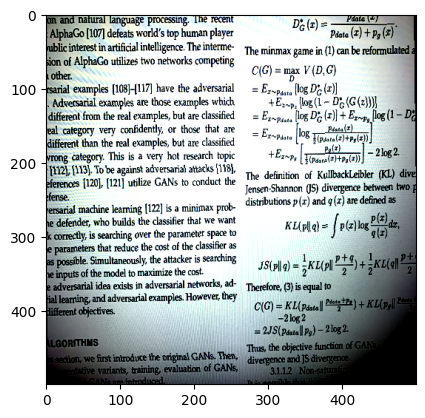

In [11]:
def show_example(img,label):
  plt.imshow(img.permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

show_example(*train_dataset[8000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([0., 0., 1., 0.])


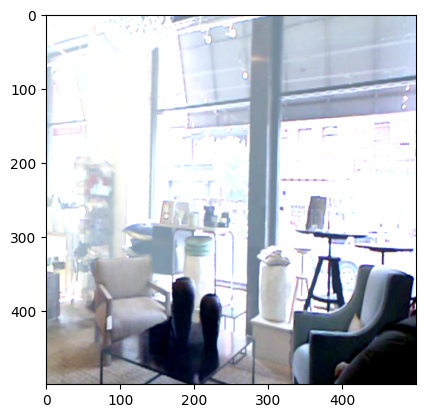

In [12]:
show_example(*val_dataset[2600])

In [13]:
train_loader = DataLoader(train_dataset, _C.BATCH_SIZE, shuffle=True, num_workers = 12)
val_loader = DataLoader(val_dataset, _C.BATCH_SIZE * 2, num_workers = 12)

In [14]:
# placeholders
#psum    = torch.tensor([0.0, 0.0, 0.0])
#psum_sq = torch.tensor([0.0, 0.0, 0.0])

# loop through images
#for inputs, target in tqdm(train_loader):
#    psum    += inputs.sum(axis        = [0, 2, 3])
#    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

In [15]:
# pixel count
#count = len(train_dataset) * _C.IMAGE_H * _C.IMAGE_W

# mean and std
#total_mean = psum / count
#total_var  = (psum_sq / count) - (total_mean ** 2)
#total_std  = torch.sqrt(total_var)

# output
#print('mean: '  + str(total_mean))
#print('std:  '  + str(total_std))

In [16]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(0, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


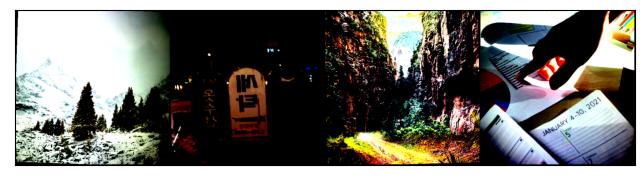

In [17]:
def show_batch(dl, nmax=16):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:nmax], nrow=4).permute(1, 2, 0))
        break

show_batch(train_loader)

In [18]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [19]:
def F_scores(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    precision, recall, F2 = [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    for i in range(4):
        precision.append(torch.mean(TP[i] / (TP[i] + FP[i] + 1e-12)))
        recall.append(torch.mean(TP[i] / (TP[i] + FN[i] + 1e-12)))
        F2_sus = (1 + beta**2) * precision[i] * recall[i] / (beta**2 * precision[i] + recall[i] + 1e-12)
        F2.append(F2_sus.mean())
    return F2

In [20]:
def TFPN(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold
    TP, TN, FP, FN = [], [], [], []
    for i in range(4):
        TP.append((prob[:,i] & label[:,i]).sum(0).float())
        TN.append(((~prob[:,i]) & (~label[:,i])).sum(0).float())
        FP.append((prob[:,i] & (~label[:,i])).sum(0).float())
        FN.append(((~prob[:,i]) & label[:,i]).sum(0).float())
    return TP, TN, FP, FN
def calc_metrics(TP, TN, FP, FN, beta=1):
    precision = TP / (TP + FP + 1e-12)
    recall = TP / (TP + FN + 1e-12)
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return precision, recall, F2

In [21]:
images, targets = next(iter(val_loader))
targets = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
preds = torch.Tensor([[1., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
TP, TN, FP, FN = TFPN(preds, targets)
print(calc_metrics(TP[0], TN[0], FP[0], FN[0]))

(tensor(0.3333), tensor(1.), tensor(0.5000))


In [22]:
def BCE_custom(preds, targets):
    losses = F.binary_cross_entropy(preds, targets, reduction='none')
    for i, target in enumerate(targets):
        for j, val in enumerate(target):
            if val == 0:
                losses[i][j] *= 0.5
    return losses.mean()

In [23]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                            # Generate predictions
        loss = BCE_custom(out, targets)   # Calculate loss
        del images
        del targets
        del out
        torch.cuda.empty_cache()
        return loss    
        
    @torch.inference_mode()
    def validation_step(self, batch):
        images, targets = batch
        out = self(images)                           # Generate predictions
        loss = BCE_custom(out, targets)              # Calculate loss
        score = F_score(out, targets)                # Calculate accuracy
        indiv_scores = F_scores(out, targets)
        TP, TN, FP, FN = TFPN(out, targets)
        del images
        del targets
        del out
        torch.cuda.empty_cache()
        return {'val_loss': loss.detach(), 
                'val_score': score.detach(), 
                'val_score_blur': indiv_scores[0].detach(), 
                'val_score_demoir': indiv_scores[1].detach(), 
                'val_score_haze': indiv_scores[2].detach(), 
                'val_score_rain': indiv_scores[3].detach(),
                'TP_blur': TP[0].detach(),
                'TP_demoir': TP[1].detach(),
                'TP_haze': TP[2].detach(),
                'TP_rain': TP[3].detach(),
                'FP_blur': FP[0].detach(),
                'FP_demoir': FP[1].detach(),
                'FP_haze': FP[2].detach(),
                'FP_rain': FP[3].detach(),
                'TN_blur': TN[0].detach(),
                'TN_demoir': TN[1].detach(),
                'TN_haze': TN[2].detach(),
                'TN_rain': TN[3].detach(),
                'FN_blur': FN[0].detach(),
                'FN_demoir': FN[1].detach(),
                'FN_haze': FN[2].detach(),
                'FN_rain': FN[3].detach()} 
    

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine losses and get the mean value
        batch_scores = [x['val_score'] for x in outputs]    
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies and get the mean value
        batch_scores_blur = [x['val_score_blur'] for x in outputs]    
        epoch_score_blur = torch.stack(batch_scores_blur).mean()      # exclusive for blur
        batch_scores_demoir = [x['val_score_demoir'] for x in outputs]    
        epoch_score_demoir = torch.stack(batch_scores_demoir).mean()      # exclusive for moire
        batch_scores_haze = [x['val_score_haze'] for x in outputs]    
        epoch_score_haze = torch.stack(batch_scores_haze).mean()      # exclusive for haze
        batch_scores_rain = [x['val_score_rain'] for x in outputs]    
        epoch_score_rain = torch.stack(batch_scores_rain).mean()      # exclusive for rain
        
        TP_blur = float(sum([x['TP_blur'] for x in outputs]))
        FP_blur = float(sum([x['FP_blur'] for x in outputs]))
        TN_blur = float(sum([x['TN_blur'] for x in outputs]))
        FN_blur = float(sum([x['FN_blur'] for x in outputs]))
        
        TP_demoir = float(sum([x['TP_demoir'] for x in outputs]))
        FP_demoir = float(sum([x['FP_demoir'] for x in outputs]))
        TN_demoir = float(sum([x['TN_demoir'] for x in outputs]))
        FN_demoir = float(sum([x['FN_demoir'] for x in outputs]))
        
        TP_haze = float(sum([x['TP_haze'] for x in outputs]))
        FP_haze = float(sum([x['FP_haze'] for x in outputs]))
        TN_haze = float(sum([x['TN_haze'] for x in outputs]))
        FN_haze = float(sum([x['FN_haze'] for x in outputs]))
        
        TP_rain = float(sum([x['TP_rain'] for x in outputs]))
        FP_rain = float(sum([x['FP_rain'] for x in outputs]))
        TN_rain = float(sum([x['TN_rain'] for x in outputs]))
        FN_rain = float(sum([x['FN_rain'] for x in outputs]))
        
        TP_total = TP_blur + TP_haze + TP_demoir + TP_rain
        FP_total = FP_blur + FP_haze + FP_demoir + FP_rain
        TN_total = TN_blur + TN_haze + TN_demoir + TN_rain
        FN_total = FN_blur + FN_haze + FN_demoir + FN_rain
        
        prec_blur, rec_blur, f2_blur = calc_metrics(TP_blur, TN_blur, FP_blur, FN_blur)
        prec_demoir, rec_demoir, f2_demoir = calc_metrics(TP_demoir, TN_demoir, FP_demoir, FN_demoir)
        prec_haze, rec_haze, f2_haze = calc_metrics(TP_haze, TN_haze, FP_haze, FN_haze)
        prec_rain, rec_rain, f2_rain = calc_metrics(TP_rain, TN_rain, FP_rain, FN_rain)
        prec_total, rec_total, f2_total = calc_metrics(TP_total, TN_total, FP_total, FN_total)
        
        print("blur")
        print(f'prec {prec_blur}, rec {rec_blur}, f2 {f2_blur}')
        print("demoir")
        print(f'prec {prec_demoir}, rec {rec_demoir}, f2 {f2_demoir}')
        print("haze")
        print(f'prec {prec_haze}, rec {rec_haze}, f2 {f2_haze}')
        print("rain")
        print(f'prec {prec_rain}, rec {rec_rain}, f2 {f2_rain}')
        return {'val_loss': epoch_loss.item(), 
                'val_score': f2_total, 
                'val_score_blur': f2_blur, 
                'val_score_haze': f2_haze, 
                'val_score_rain': f2_rain, 
                'val_score_demoir': f2_demoir}    

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}, val_score_blur: {:.4f}, val_score_demoir: {:.4f}, val_score_haze: {:.4f}, val_score_rain: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score'], result['val_score_blur'], result['val_score_demoir'], result['val_score_haze'], result['val_score_rain']))

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')  


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():  
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device       

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [25]:
#loading training and validation data onto GPU
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

In [26]:
# checking up the shapes of the datas
for xb, yb in train_dl:
  print(xb.shape)
  print(yb.shape)
  del xb
  del yb
  torch.cuda.empty_cache()
  break

torch.Size([4, 3, 500, 500])
torch.Size([4, 4])


In [27]:
from tqdm.notebook import tqdm

def save_model(model):
    PATH = os.path.join('saved_models', datetime.now().strftime('%d-%m-%y-%H_%M_dqnweights.pt'))
    torch.save(model.state_dict(), PATH)

def load_model(path):
    loaded_model = CustomModel().to(device)
    loaded_model.load_state_dict(torch.load('saved_models/08-05-23-02_49_dqnweights.pt'))
    loaded_model.eval()
    return loaded_model

@torch.inference_mode()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)) #schedule the learning rate with OneCycleLR
    
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]

    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


class ResNet15(MultilabelImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()     
        #input 3 x 500 x 500
        self.conv1 = conv_block(in_channels, 64)  #output 64 x 500 x 500
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) #output 64 x 500 x 500


        self.conv2 = conv_block(64, 128, pool=True) #output 128 x 120 x 120
        self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128), conv_block(128, 128))  #output 128 x 120 x 120  


        self.conv3 = conv_block(128, 512, pool=True) #output 512 x 30 x 30
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) #output 512 x 30 x 30


        self.conv4 = conv_block(512, 1024, pool=True) #output 1024 x 7 x 7
        self.res4 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024)) #output 1024 x 7 x 7


        self.classifier = nn.Sequential(nn.MaxPool2d(7), #output 1024 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 1 * 1, 512), #output 512
                                        nn.ReLU(),
                                        nn.Linear(512, num_classes)) #output 4    

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.conv4(out)
        out = self.res4(out) + out
        out = self.classifier(out)
        out = torch.sigmoid(out)
        return out

Model number 2: Mobilenet v2 from torchhub
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [34]:
class CustomModel(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=None)
        self.model.classifier = nn.Sequential(
          nn.Linear(1280, 512),
          nn.Dropout(0.2),
          nn.ReLU(),
          nn.Linear(512, 256),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(256, 64),
          nn.Dropout(0.3),
          nn.ReLU(),
          nn.Linear(64, 4)
        )
        
    def freeze_model(self):
        for param in self.model.parameters():
            param.requires_grad = False
    def unfreeze_for_train(self):
        for param in self.model.classifier.parameters():
            param.requires_grad = True
    def forward(self, xb):
        out = self.model(xb)
        out = torch.sigmoid(out)
        return out

In [35]:
model = CustomModel().to(device)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

Using cache found in /home/berezerker/.cache/torch/hub/pytorch_vision_v0.10.0


3027780

In [36]:
#checking the shape of outputs that the model will produce before starting the training process
for images, labels in train_dl:
    print(images.shape)
    outputs = model(images)
    del images
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)
del outputs

torch.Size([4, 3, 500, 500])
outputs.shape :  torch.Size([4, 4])
Sample outputs :
 tensor([[0.5125, 0.4848, 0.5340, 0.5359],
        [0.5132, 0.4924, 0.5323, 0.5358]], device='cuda:0')


In [37]:
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
r, a

(1688207360, 12329984)

In [38]:
epochs = 10
max_lr = 0.001
grad_clip = 0.9
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [39]:
history = [evaluate(model, val_dl)]
history

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.2599311136624569, rec 0.9999999999999992, f2 0.41261162748281427
demoir
prec 0.0, rec 0.0, f2 0.0
haze
prec 0.27554535017221576, rec 0.9999999999999992, f2 0.43204320432009313
rain
prec 0.23490241102181394, rec 0.999999999999999, f2 0.38043882484164043


[{'val_loss': 0.43739399313926697,
  'val_score': 0.3851894374278683,
  'val_score_blur': 0.41261162748281427,
  'val_score_haze': 0.43204320432009313,
  'val_score_rain': 0.38043882484164043,
  'val_score_demoir': 0.0}]

In [40]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9554263565891464, rec 0.8710247349823315, f2 0.9112754158959883
demoir
prec 0.7317666126418148, rec 0.902999999999999, f2 0.8084153983880455
haze
prec 0.8133608815426993, rec 0.984166666666666, f2 0.8906485671186593
rain
prec 0.923076923076922, rec 0.7976539589442807, f2 0.8557944415307025
Epoch [0], last_lr: 0.0003, train_loss: 0.2672, val_loss: 0.1333, val_score: 0.8677, val_score_blur: 0.9113, val_score_demoir: 0.8084, val_score_haze: 0.8906, val_score_rain: 0.8558


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9708636836628501, rec 0.8242049469964657, f2 0.8915432393688287
demoir
prec 0.8219178082191774, rec 0.8999999999999991, f2 0.8591885441522449
haze
prec 0.9197994987468665, rec 0.9174999999999993, f2 0.9186483103874842
rain
prec 0.7395596051632493, rec 0.9521016617790802, f2 0.8324786324781397
Epoch [1], last_lr: 0.0008, train_loss: 0.1994, val_loss: 0.1389, val_score: 0.8757, val_score_blur: 0.8915, val_score_demoir: 0.8592, val_score_haze: 0.9186, val_score_rain: 0.8325


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.8566694283347135, rec 0.9134275618374551, f2 0.8841385207348568
demoir
prec 0.9421894218942177, rec 0.7659999999999992, f2 0.8450082735792066
haze
prec 0.8215511324639665, rec 0.9974999999999993, f2 0.9010161836652925
rain
prec 0.9071856287425141, rec 0.8885630498533715, f2 0.897777777777277
Epoch [2], last_lr: 0.0010, train_loss: 0.1912, val_loss: 0.1198, val_score: 0.8843, val_score_blur: 0.8841, val_score_demoir: 0.8450, val_score_haze: 0.9010, val_score_rain: 0.8978


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9583333333333326, rec 0.9549469964664303, f2 0.9566371681410921
demoir
prec 0.9458874458874449, rec 0.8739999999999991, f2 0.9085239085234084
haze
prec 0.9101294744859095, rec 0.9958333333333326, f2 0.9510545165136268
rain
prec 0.8589626933575971, rec 0.9227761485825993, f2 0.8897266729495469
Epoch [3], last_lr: 0.0010, train_loss: 0.1607, val_loss: 0.0690, val_score: 0.9284, val_score_blur: 0.9566, val_score_demoir: 0.9085, val_score_haze: 0.9511, val_score_rain: 0.8897


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.8888888888888883, rec 0.9752650176678438, f2 0.930075821397984
demoir
prec 0.9128630705394181, rec 0.8799999999999991, f2 0.8961303462316784
haze
prec 0.9644588045234241, rec 0.9949999999999992, f2 0.9794913863817798
rain
prec 0.8996062992125975, rec 0.8934506353861184, f2 0.8965179009313284
Epoch [4], last_lr: 0.0008, train_loss: 0.1270, val_loss: 0.0669, val_score: 0.9284, val_score_blur: 0.9301, val_score_demoir: 0.8961, val_score_haze: 0.9795, val_score_rain: 0.8965


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9418084153983878, rec 0.9293286219081265, f2 0.9355269008443191
demoir
prec 0.8374892519346511, rec 0.973999999999999, f2 0.9006010171053734
haze
prec 0.9695723684210519, rec 0.9824999999999993, f2 0.9759933774829429
rain
prec 0.9033175355450229, rec 0.9315738025415435, f2 0.9172281039456012
Epoch [5], last_lr: 0.0006, train_loss: 0.1021, val_loss: 0.0679, val_score: 0.9338, val_score_blur: 0.9355, val_score_demoir: 0.9006, val_score_haze: 0.9760, val_score_rain: 0.9172


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9740143369175619, rec 0.9602473498233208, f2 0.9670818505333071
demoir
prec 0.9587939698492453, rec 0.9539999999999991, f2 0.9563909774431081
haze
prec 0.9411302982731548, rec 0.9991666666666659, f2 0.9692805173802597
rain
prec 0.9566074950690325, rec 0.9481915933528827, f2 0.9523809523804514
Epoch [6], last_lr: 0.0004, train_loss: 0.0794, val_loss: 0.0415, val_score: 0.9618, val_score_blur: 0.9671, val_score_demoir: 0.9564, val_score_haze: 0.9693, val_score_rain: 0.9524


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9826800364630803, rec 0.9522968197879851, f2 0.967249887841581
demoir
prec 0.9321533923303825, rec 0.9479999999999991, f2 0.9400099157159096
haze
prec 0.9771986970684032, rec 0.9999999999999992, f2 0.9884678747935685
rain
prec 0.8995475113122164, rec 0.9716520039100675, f2 0.9342105263152893
Epoch [7], last_lr: 0.0002, train_loss: 0.0603, val_loss: 0.0404, val_score: 0.9589, val_score_blur: 0.9672, val_score_demoir: 0.9400, val_score_haze: 0.9885, val_score_rain: 0.9342


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.982789855072463, rec 0.958480565371024, f2 0.9704830053662256
demoir
prec 0.9519607843137246, rec 0.970999999999999, f2 0.9613861386133604
haze
prec 0.9950166112956803, rec 0.9983333333333326, f2 0.9966722129778685
rain
prec 0.9194139194139187, rec 0.9814271749755611, f2 0.9494089834510363
Epoch [8], last_lr: 0.0000, train_loss: 0.0462, val_loss: 0.0297, val_score: 0.9705, val_score_blur: 0.9705, val_score_demoir: 0.9614, val_score_haze: 0.9967, val_score_rain: 0.9494


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.981818181818181, rec 0.9540636042402819, f2 0.9677419354833702
demoir
prec 0.9608433734939749, rec 0.9569999999999991, f2 0.9589178356708417
haze
prec 0.9771986970684032, rec 0.9999999999999992, f2 0.9884678747935685
rain
prec 0.9173553719008257, rec 0.9765395894428143, f2 0.9460227272722269
Epoch [9], last_lr: 0.0000, train_loss: 0.0408, val_loss: 0.0367, val_score: 0.9662, val_score_blur: 0.9677, val_score_demoir: 0.9589, val_score_haze: 0.9885, val_score_rain: 0.9460
CPU times: user 40min 44s, sys: 4min 24s, total: 45min 8s
Wall time: 54min 22s


In [41]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9852262234533694, rec 0.9425795053003526, f2 0.9634311512410344
demoir
prec 0.9534883720930223, rec 0.9429999999999991, f2 0.9482151835088001
haze
prec 0.9638554216867463, rec 0.9999999999999992, f2 0.9815950920240392
rain
prec 0.9083409715857005, rec 0.9687194525904194, f2 0.9375591296116095
Epoch [0], last_lr: 0.0003, train_loss: 0.0436, val_loss: 0.0425, val_score: 0.9588, val_score_blur: 0.9634, val_score_demoir: 0.9482, val_score_haze: 0.9816, val_score_rain: 0.9376


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9176954732510281, rec 0.9849823321554763, f2 0.9501491265440247
demoir
prec 0.9630021141649038, rec 0.910999999999999, f2 0.9362795477898385
haze
prec 0.9787408013082577, rec 0.9974999999999993, f2 0.9880313660746128
rain
prec 0.9143932267168383, rec 0.9501466275659814, f2 0.9319271332689144
Epoch [1], last_lr: 0.0008, train_loss: 0.0661, val_loss: 0.0469, val_score: 0.9532, val_score_blur: 0.9501, val_score_demoir: 0.9363, val_score_haze: 0.9880, val_score_rain: 0.9319


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.8844911147011302, rec 0.967314487632508, f2 0.9240506329108926
demoir
prec 0.9578163771712147, rec 0.7719999999999992, f2 0.8549280177182202
haze
prec 0.8232462173314988, rec 0.9974999999999993, f2 0.9020346646566253
rain
prec 0.8755980861244012, rec 0.8944281524926677, f2 0.8849129593805437
Epoch [2], last_lr: 0.0010, train_loss: 0.0902, val_loss: 0.1046, val_score: 0.8944, val_score_blur: 0.9241, val_score_demoir: 0.8549, val_score_haze: 0.9020, val_score_rain: 0.8849


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9622807017543852, rec 0.9690812720848049, f2 0.9656690140840062
demoir
prec 0.9770491803278678, rec 0.8939999999999991, f2 0.9336814621404921
haze
prec 0.9531001589825112, rec 0.9991666666666659, f2 0.9755899104958379
rain
prec 0.9053201082055898, rec 0.9814271749755611, f2 0.9418386491552222
Epoch [3], last_lr: 0.0010, train_loss: 0.0920, val_loss: 0.0453, val_score: 0.9557, val_score_blur: 0.9657, val_score_demoir: 0.9337, val_score_haze: 0.9756, val_score_rain: 0.9418


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9400352733686059, rec 0.9416961130742042, f2 0.9408649602819352
demoir
prec 0.9259634888438124, rec 0.912999999999999, f2 0.9194360523660651
haze
prec 0.9309006211180118, rec 0.9991666666666659, f2 0.9638263665589855
rain
prec 0.9144736842105256, rec 0.9511241446725308, f2 0.9324389075222592
Epoch [4], last_lr: 0.0008, train_loss: 0.0798, val_loss: 0.0619, val_score: 0.9405, val_score_blur: 0.9409, val_score_demoir: 0.9194, val_score_haze: 0.9638, val_score_rain: 0.9324


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9617391304347819, rec 0.9770318021201405, f2 0.9693251533737323
demoir
prec 0.9731404958677675, rec 0.9419999999999991, f2 0.9573170731702308
haze
prec 0.9615076182838806, rec 0.9991666666666659, f2 0.9799754801793115
rain
prec 0.945506692160611, rec 0.9667644183773206, f2 0.9560173997095038
Epoch [5], last_lr: 0.0006, train_loss: 0.0687, val_loss: 0.0366, val_score: 0.9665, val_score_blur: 0.9693, val_score_demoir: 0.9573, val_score_haze: 0.9800, val_score_rain: 0.9560


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9622964867180798, rec 0.9920494699646635, f2 0.9769464984770982
demoir
prec 0.9843587069864431, rec 0.9439999999999991, f2 0.9637570188866865
haze
prec 0.9933719966859976, rec 0.9991666666666659, f2 0.9962609056912316
rain
prec 0.9149130832570899, rec 0.9775171065493636, f2 0.9451795841204826
Epoch [6], last_lr: 0.0004, train_loss: 0.0532, val_loss: 0.0305, val_score: 0.9716, val_score_blur: 0.9769, val_score_demoir: 0.9638, val_score_haze: 0.9963, val_score_rain: 0.9452


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9662629757785459, rec 0.9867491166077731, f2 0.9763986013981006
demoir
prec 0.9699097291875617, rec 0.966999999999999, f2 0.9684526790180268
haze
prec 0.9892739273927386, rec 0.9991666666666659, f2 0.9941956882250381
rain
prec 0.9460227272727264, rec 0.9765395894428143, f2 0.9610389610384602
Epoch [7], last_lr: 0.0002, train_loss: 0.0413, val_loss: 0.0253, val_score: 0.9758, val_score_blur: 0.9764, val_score_demoir: 0.9685, val_score_haze: 0.9942, val_score_rain: 0.9610


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9638865004299219, rec 0.9902826855123666, f2 0.9769063180822879
demoir
prec 0.9682539682539673, rec 0.975999999999999, f2 0.9721115537843596
haze
prec 0.995020746887966, rec 0.9991666666666659, f2 0.9970893970888962
rain
prec 0.9697560975609747, rec 0.9716520039100675, f2 0.970703124999499
Epoch [8], last_lr: 0.0000, train_loss: 0.0332, val_loss: 0.0205, val_score: 0.9799, val_score_blur: 0.9769, val_score_demoir: 0.9721, val_score_haze: 0.9971, val_score_rain: 0.9707


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9788918205804742, rec 0.9832155477031794, f2 0.981048920228675
demoir
prec 0.9730538922155678, rec 0.974999999999999, f2 0.974025974025473
haze
prec 0.9966722129783686, rec 0.9983333333333326, f2 0.997502081598167
rain
prec 0.950897072710103, rec 0.9843597262952092, f2 0.9673390970215934
Epoch [9], last_lr: 0.0000, train_loss: 0.0272, val_loss: 0.0188, val_score: 0.9807, val_score_blur: 0.9810, val_score_demoir: 0.9740, val_score_haze: 0.9975, val_score_rain: 0.9673


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9926402943882237, rec 0.9531802120141335, f2 0.9725101397020681
demoir
prec 0.962671905697445, rec 0.979999999999999, f2 0.9712586719519272
haze
prec 0.9884678747940685, rec 0.9999999999999992, f2 0.9942004970997477
rain
prec 0.9248395967002742, rec 0.9863147605083079, f2 0.9545884578992158
Epoch [0], last_lr: 0.0003, train_loss: 0.0341, val_loss: 0.0279, val_score: 0.9739, val_score_blur: 0.9725, val_score_demoir: 0.9713, val_score_haze: 0.9942, val_score_rain: 0.9546


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9783588818755627, rec 0.958480565371024, f2 0.9683177153051663
demoir
prec 0.9646201873048897, rec 0.926999999999999, f2 0.9454360020392748
haze
prec 0.9817427385892109, rec 0.9858333333333326, f2 0.9837837837832829
rain
prec 0.8452579034941757, rec 0.9931573802541535, f2 0.9132584269657945
Epoch [1], last_lr: 0.0008, train_loss: 0.0486, val_loss: 0.0462, val_score: 0.9536, val_score_blur: 0.9683, val_score_demoir: 0.9454, val_score_haze: 0.9838, val_score_rain: 0.9133


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9436379163108447, rec 0.9761484098939921, f2 0.9596178897085745
demoir
prec 0.949404761904761, rec 0.9569999999999991, f2 0.953187250995515
haze
prec 0.9771054783319698, rec 0.9958333333333326, f2 0.9863805200160077
rain
prec 0.9372586872586864, rec 0.9491691104594321, f2 0.9431762991738555
Epoch [2], last_lr: 0.0010, train_loss: 0.0672, val_loss: 0.0410, val_score: 0.9617, val_score_blur: 0.9596, val_score_demoir: 0.9532, val_score_haze: 0.9864, val_score_rain: 0.9432


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9525452976704047, rec 0.9752650176678438, f2 0.9637712789170026
demoir
prec 0.9561965811965801, rec 0.8949999999999991, f2 0.9245867768590037
haze
prec 0.9567654123298632, rec 0.9958333333333326, f2 0.9759085340950487
rain
prec 0.9147940074906359, rec 0.9550342130987283, f2 0.9344811095164768
Epoch [3], last_lr: 0.0010, train_loss: 0.0705, val_loss: 0.0535, val_score: 0.9515, val_score_blur: 0.9638, val_score_demoir: 0.9246, val_score_haze: 0.9759, val_score_rain: 0.9345


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9508474576271179, rec 0.9911660777385151, f2 0.9705882352936169
demoir
prec 0.9735503560528983, rec 0.9569999999999991, f2 0.9652042360055505
haze
prec 0.9950166112956803, rec 0.9983333333333326, f2 0.9966722129778685
rain
prec 0.9362699156513582, rec 0.9765395894428143, f2 0.9559808612435184
Epoch [4], last_lr: 0.0008, train_loss: 0.0619, val_loss: 0.0314, val_score: 0.9730, val_score_blur: 0.9706, val_score_demoir: 0.9652, val_score_haze: 0.9967, val_score_rain: 0.9560


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9719457013574653, rec 0.9487632508833914, f2 0.9602145730884577
demoir
prec 0.9727547931382432, rec 0.963999999999999, f2 0.968357609241086
haze
prec 0.9762684124386245, rec 0.9941666666666659, f2 0.985136251031704
rain
prec 0.9156844968268352, rec 0.9872922776148573, f2 0.9501411100653512
Epoch [5], last_lr: 0.0006, train_loss: 0.0529, val_loss: 0.0346, val_score: 0.9665, val_score_blur: 0.9602, val_score_demoir: 0.9684, val_score_haze: 0.9851, val_score_rain: 0.9501


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9565595134665501, rec 0.9726148409893985, f2 0.9645203679364243
demoir
prec 0.9710578842315359, rec 0.972999999999999, f2 0.9720279720274709
haze
prec 0.9677419354838702, rec 0.9999999999999992, f2 0.9836065573765485
rain
prec 0.9802566633761096, rec 0.9706744868035181, f2 0.975442043221503
Epoch [6], last_lr: 0.0004, train_loss: 0.0406, val_loss: 0.0313, val_score: 0.9741, val_score_blur: 0.9645, val_score_demoir: 0.9720, val_score_haze: 0.9836, val_score_rain: 0.9754


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9694244604316539, rec 0.9522968197879851, f2 0.9607843137249894
demoir
prec 0.9471661863592691, rec 0.985999999999999, f2 0.9661930426256629
haze
prec 0.9974704890387851, rec 0.9858333333333326, f2 0.9916177703264062
rain
prec 0.9500471253534394, rec 0.9853372434017585, f2 0.9673704414582325
Epoch [7], last_lr: 0.0002, train_loss: 0.0338, val_loss: 0.0276, val_score: 0.9720, val_score_blur: 0.9608, val_score_demoir: 0.9662, val_score_haze: 0.9916, val_score_rain: 0.9674


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9531116794543897, rec 0.9876325088339215, f2 0.9700650759214082
demoir
prec 0.9732673267326722, rec 0.982999999999999, f2 0.9781094527358174
haze
prec 0.9991561181434592, rec 0.9866666666666659, f2 0.9928721173999185
rain
prec 0.9709583736689246, rec 0.9804496578690117, f2 0.9756809338516391
Epoch [8], last_lr: 0.0000, train_loss: 0.0273, val_loss: 0.0211, val_score: 0.9794, val_score_blur: 0.9701, val_score_demoir: 0.9781, val_score_haze: 0.9929, val_score_rain: 0.9757


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9728546409807348, rec 0.9814487632508826, f2 0.977132805628347
demoir
prec 0.983983983983983, rec 0.982999999999999, f2 0.9834917458724355
haze
prec 0.9966722129783686, rec 0.9983333333333326, f2 0.997502081598167
rain
prec 0.9663137632338779, rec 0.9814271749755611, f2 0.9738118331711769
Epoch [9], last_lr: 0.0000, train_loss: 0.0222, val_loss: 0.0185, val_score: 0.9834, val_score_blur: 0.9771, val_score_demoir: 0.9835, val_score_haze: 0.9975, val_score_rain: 0.9738


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9654278305963692, rec 0.9867491166077731, f2 0.9759720401917229
demoir
prec 0.9897225077081182, rec 0.962999999999999, f2 0.9761784085144509
haze
prec 0.9950041631973348, rec 0.9958333333333326, f2 0.995418575593002
rain
prec 0.9599999999999992, rec 0.9853372434017585, f2 0.9725036179445063
Epoch [0], last_lr: 0.0003, train_loss: 0.0264, val_loss: 0.0231, val_score: 0.9805, val_score_blur: 0.9760, val_score_demoir: 0.9762, val_score_haze: 0.9954, val_score_rain: 0.9725


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9207673060884063, rec 0.9752650176678438, f2 0.9472329472324469
demoir
prec 0.9746963562753026, rec 0.962999999999999, f2 0.9688128772630804
haze
prec 0.9661563255439155, rec 0.9991666666666659, f2 0.9823842687418182
rain
prec 0.9776876267748469, rec 0.9423264907135865, f2 0.9596814335485285
Epoch [1], last_lr: 0.0008, train_loss: 0.0404, val_loss: 0.0375, val_score: 0.9648, val_score_blur: 0.9472, val_score_demoir: 0.9688, val_score_haze: 0.9824, val_score_rain: 0.9597


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9598930481283414, rec 0.9514134275618367, f2 0.9556344276836163
demoir
prec 0.9257473481195749, rec 0.959999999999999, f2 0.9425625920466274
haze
prec 0.9638263665594848, rec 0.9991666666666659, f2 0.9811783960715125
rain
prec 0.9613095238095228, rec 0.9472140762463334, f2 0.9542097488916703
Epoch [2], last_lr: 0.0010, train_loss: 0.0548, val_loss: 0.0403, val_score: 0.9594, val_score_blur: 0.9556, val_score_demoir: 0.9426, val_score_haze: 0.9812, val_score_rain: 0.9542


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9576124567474041, rec 0.9779151943462889, f2 0.9676573426568418
demoir
prec 0.975103734439833, rec 0.9399999999999991, f2 0.9572301425656905
haze
prec 0.9884678747940685, rec 0.9999999999999992, f2 0.9942004970997477
rain
prec 0.9295774647887316, rec 0.96774193548387, f2 0.9482758620684647
Epoch [3], last_lr: 0.0010, train_loss: 0.0588, val_loss: 0.0348, val_score: 0.9680, val_score_blur: 0.9677, val_score_demoir: 0.9572, val_score_haze: 0.9942, val_score_rain: 0.9483


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.983812949640287, rec 0.9664310954063596, f2 0.9750445632793566
demoir
prec 0.9653808110781394, rec 0.975999999999999, f2 0.9706613625057148
haze
prec 0.9925249169435209, rec 0.9958333333333326, f2 0.9941763727116457
rain
prec 0.9271889400921651, rec 0.9833822091886598, f2 0.9544592030355525
Epoch [4], last_lr: 0.0008, train_loss: 0.0542, val_loss: 0.0278, val_score: 0.9743, val_score_blur: 0.9750, val_score_demoir: 0.9707, val_score_haze: 0.9942, val_score_rain: 0.9545


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9770318021201405, rec 0.9770318021201405, f2 0.9770318021196405
demoir
prec 0.9587426326129657, rec 0.975999999999999, f2 0.9672943508419173
haze
prec 0.9933719966859976, rec 0.9991666666666659, f2 0.9962609056912316
rain
prec 0.9561068702290068, rec 0.9794721407624624, f2 0.9676484789951533
Epoch [5], last_lr: 0.0006, train_loss: 0.0473, val_loss: 0.0258, val_score: 0.9779, val_score_blur: 0.9770, val_score_demoir: 0.9673, val_score_haze: 0.9963, val_score_rain: 0.9676


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9822222222222214, rec 0.9761484098939921, f2 0.9791758972081832
demoir
prec 0.9599217986314751, rec 0.981999999999999, f2 0.9708353929802207
haze
prec 0.9933665008291866, rec 0.9983333333333326, f2 0.9958437240227744
rain
prec 0.9635666347075734, rec 0.9824046920821105, f2 0.9728944820904962
Epoch [6], last_lr: 0.0004, train_loss: 0.0360, val_loss: 0.0211, val_score: 0.9803, val_score_blur: 0.9792, val_score_demoir: 0.9708, val_score_haze: 0.9958, val_score_rain: 0.9729


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9823165340406712, rec 0.9814487632508826, f2 0.9818824569150979
demoir
prec 0.9474187380497123, rec 0.990999999999999, f2 0.9687194525899195
haze
prec 0.995020746887966, rec 0.9991666666666659, f2 0.9970893970888962
rain
prec 0.9821958456973284, rec 0.9706744868035181, f2 0.9764011799405019
Epoch [7], last_lr: 0.0002, train_loss: 0.0290, val_loss: 0.0198, val_score: 0.9817, val_score_blur: 0.9819, val_score_demoir: 0.9687, val_score_haze: 0.9971, val_score_rain: 0.9764


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9807186678352314, rec 0.9885159010600699, f2 0.9846018477777658
demoir
prec 0.9771371769383688, rec 0.982999999999999, f2 0.9800598205378838
haze
prec 0.9958471760797335, rec 0.9991666666666659, f2 0.9975041597332761
rain
prec 0.9796116504854361, rec 0.9863147605083079, f2 0.9829517778855195
Epoch [8], last_lr: 0.0000, train_loss: 0.0232, val_loss: 0.0149, val_score: 0.9867, val_score_blur: 0.9846, val_score_demoir: 0.9801, val_score_haze: 0.9975, val_score_rain: 0.9830


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9858906525573184, rec 0.9876325088339215, f2 0.9867608120030296
demoir
prec 0.9639376218323579, rec 0.988999999999999, f2 0.9763079960508318
haze
prec 0.995020746887966, rec 0.9991666666666659, f2 0.9970893970888962
rain
prec 0.9882121807465609, rec 0.9833822091886598, f2 0.9857912787844084
Epoch [9], last_lr: 0.0000, train_loss: 0.0199, val_loss: 0.0151, val_score: 0.9870, val_score_blur: 0.9868, val_score_demoir: 0.9763, val_score_haze: 0.9971, val_score_rain: 0.9858


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9746503496503489, rec 0.9849823321554763, f2 0.9797891036901847
demoir
prec 0.9431279620853072, rec 0.994999999999999, f2 0.9683698296831977
haze
prec 0.9991610738255026, rec 0.9924999999999993, f2 0.9958193979928103
rain
prec 0.9803343166175015, rec 0.9745845552297155, f2 0.9774509803916559
Epoch [0], last_lr: 0.0003, train_loss: 0.0223, val_loss: 0.0222, val_score: 0.9809, val_score_blur: 0.9798, val_score_demoir: 0.9684, val_score_haze: 0.9958, val_score_rain: 0.9775


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9953574744661087, rec 0.9469964664310947, f2 0.9705749207781322
demoir
prec 0.9723593287265538, rec 0.984999999999999, f2 0.9786388474908054
haze
prec 0.9592326139088722, rec 0.9999999999999992, f2 0.9791921664621677
rain
prec 0.9712643678160912, rec 0.9912023460410547, f2 0.9811320754711972
Epoch [1], last_lr: 0.0008, train_loss: 0.0344, val_loss: 0.0270, val_score: 0.9773, val_score_blur: 0.9706, val_score_demoir: 0.9786, val_score_haze: 0.9792, val_score_rain: 0.9811


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9033037872683314, rec 0.9902826855123666, f2 0.9447956173614893
demoir
prec 0.9811529933481142, rec 0.8849999999999991, f2 0.9305993690846738
haze
prec 0.9966694421315563, rec 0.9974999999999993, f2 0.9970845481044553
rain
prec 0.9274418604651155, rec 0.9745845552297155, f2 0.9504289799804335
Epoch [2], last_lr: 0.0010, train_loss: 0.0480, val_loss: 0.0466, val_score: 0.9574, val_score_blur: 0.9448, val_score_demoir: 0.9306, val_score_haze: 0.9971, val_score_rain: 0.9504


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9537521815008718, rec 0.9655477031802112, f2 0.9596136962242577
demoir
prec 0.9596774193548377, rec 0.9519999999999991, f2 0.9558232931721898
haze
prec 0.9795918367346932, rec 0.9999999999999992, f2 0.9896907216489839
rain
prec 0.9393364928909944, rec 0.9687194525904194, f2 0.9538017324345329
Epoch [3], last_lr: 0.0010, train_loss: 0.0510, val_loss: 0.0364, val_score: 0.9657, val_score_blur: 0.9596, val_score_demoir: 0.9558, val_score_haze: 0.9897, val_score_rain: 0.9538


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9555749128919853, rec 0.9690812720848049, f2 0.9622807017538852
demoir
prec 0.9452590420332346, rec 0.966999999999999, f2 0.9560059317839775
haze
prec 0.9983263598326352, rec 0.9941666666666659, f2 0.9962421711894783
rain
prec 0.963496637848222, rec 0.9804496578690117, f2 0.9718992248057007
Epoch [4], last_lr: 0.0008, train_loss: 0.0479, val_loss: 0.0302, val_score: 0.9724, val_score_blur: 0.9623, val_score_demoir: 0.9560, val_score_haze: 0.9962, val_score_rain: 0.9719


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.97885462555066, rec 0.9814487632508826, f2 0.9801499779439192
demoir
prec 0.9781094527363174, rec 0.982999999999999, f2 0.9805486284284267
haze
prec 0.992555831265508, rec 0.9999999999999992, f2 0.9962640099621393
rain
prec 0.97391304347826, rec 0.9853372434017585, f2 0.9795918367341929
Epoch [5], last_lr: 0.0006, train_loss: 0.0434, val_loss: 0.0191, val_score: 0.9846, val_score_blur: 0.9801, val_score_demoir: 0.9805, val_score_haze: 0.9963, val_score_rain: 0.9796


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9797713280562877, rec 0.9840989399293278, f2 0.9819303657994112
demoir
prec 0.9742828882294747, rec 0.984999999999999, f2 0.9796121332665303
haze
prec 0.9909165978530133, rec 0.9999999999999992, f2 0.99543757776806
rain
prec 0.9832841691248762, rec 0.9775171065493636, f2 0.980392156862244
Epoch [6], last_lr: 0.0004, train_loss: 0.0323, val_loss: 0.0178, val_score: 0.9848, val_score_blur: 0.9819, val_score_demoir: 0.9796, val_score_haze: 0.9954, val_score_rain: 0.9804


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9706136560069136, rec 0.9920494699646635, f2 0.9812145041497832
demoir
prec 0.9829488465396179, rec 0.979999999999999, f2 0.9814722083119677
haze
prec 0.9975062344139644, rec 0.9999999999999992, f2 0.9987515605488125
rain
prec 0.9795719844357968, rec 0.9843597262952092, f2 0.9819600195021806
Epoch [7], last_lr: 0.0002, train_loss: 0.0246, val_loss: 0.0159, val_score: 0.9863, val_score_blur: 0.9812, val_score_demoir: 0.9815, val_score_haze: 0.9988, val_score_rain: 0.9820


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.976480836236933, rec 0.9902826855123666, f2 0.9833333333328326
demoir
prec 0.9887755102040806, rec 0.968999999999999, f2 0.9787878787873777
haze
prec 0.9975062344139644, rec 0.9999999999999992, f2 0.9987515605488125
rain
prec 0.9731800766283516, rec 0.9931573802541535, f2 0.9830672472176898
Epoch [8], last_lr: 0.0000, train_loss: 0.0193, val_loss: 0.0158, val_score: 0.9865, val_score_blur: 0.9833, val_score_demoir: 0.9788, val_score_haze: 0.9988, val_score_rain: 0.9831


  0%|          | 0/4298 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9790209790209783, rec 0.9893992932862183, f2 0.9841827768009052
demoir
prec 0.9760956175298795, rec 0.979999999999999, f2 0.9780439121751476
haze
prec 0.9958506224066382, rec 0.9999999999999992, f2 0.9979209979204972
rain
prec 0.976833976833976, rec 0.989247311827956, f2 0.9830014570174689
Epoch [9], last_lr: 0.0000, train_loss: 0.0172, val_loss: 0.0146, val_score: 0.9863, val_score_blur: 0.9842, val_score_demoir: 0.9780, val_score_haze: 0.9979, val_score_rain: 0.9830


In [42]:
evaluate(model, val_dl)

  0%|          | 0/545 [00:00<?, ?it/s]

blur
prec 0.9790209790209783, rec 0.9893992932862183, f2 0.9841827768009052
demoir
prec 0.9760956175298795, rec 0.979999999999999, f2 0.9780439121751476
haze
prec 0.9958506224066382, rec 0.9999999999999992, f2 0.9979209979204972
rain
prec 0.976833976833976, rec 0.989247311827956, f2 0.9830014570174689


{'val_loss': 0.014585237950086594,
 'val_score': 0.9862763037506433,
 'val_score_blur': 0.9841827768009052,
 'val_score_haze': 0.9979209979204972,
 'val_score_rain': 0.9830014570174689,
 'val_score_demoir': 0.9780439121751476}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([2.7494e-08, 1.0000e+00, 7.0922e-11, 8.8757e-07], device='cuda:0',
       grad_fn=<SelectBackward0>)


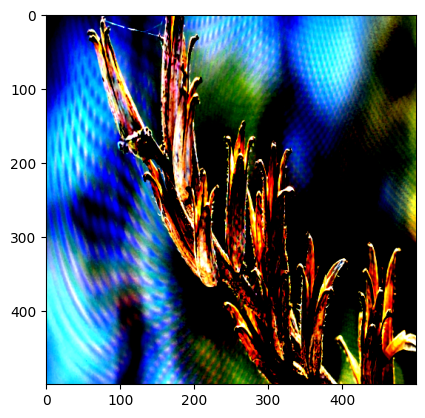

In [43]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_dataset[1500][0])

In [44]:
for i, data in enumerate(val_dataset):
    image = data[0]
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    pred_label = decode_target(prediction)
    tar_label = decode_target(data[1])
    if pred_label != tar_label:
        print(i)

17
48
57
63
73
75
97
101
144
147
149
204
281
294
348
642
696
744
751
797
932
1132
1164
1184
1190
1196
1204
1229
1236
1289
1318
1344
1370
1387
1391
1402
1438
1444
1495
1508
1532
1544
1554
1605
1855
1868
1986
2053
2089
2090
2127
3358
3360
3381
3400
3409
3415
3433
3434
3470
3490
3498
3507
3520
3523
3524
3531
3533
3534
3536
3537
3541
3549
3550
3567
3652
3788
4146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([7.0273e-08, 1.0000e+00, 2.3206e-10, 1.8478e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)


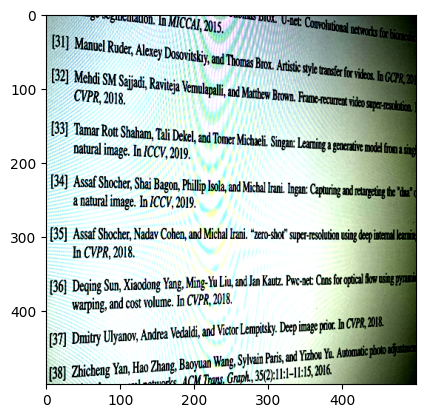

In [45]:
predict_single(val_dataset[1258][0])

In [46]:
val_dataset.im_path(1258)

'test/demoir/0126_moire.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: demoir

tensor([0., 1., 0., 0.])


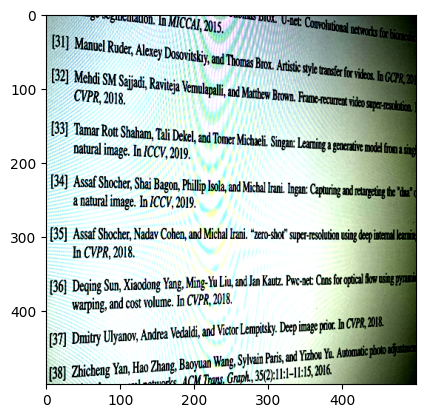

In [47]:
show_example(*val_dataset[1258])

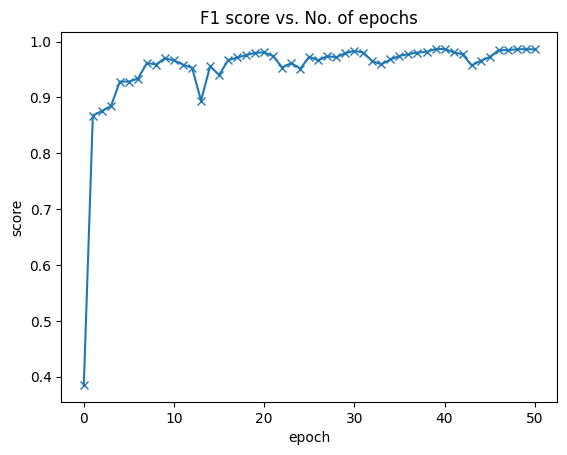

In [48]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');
plot_scores(history)

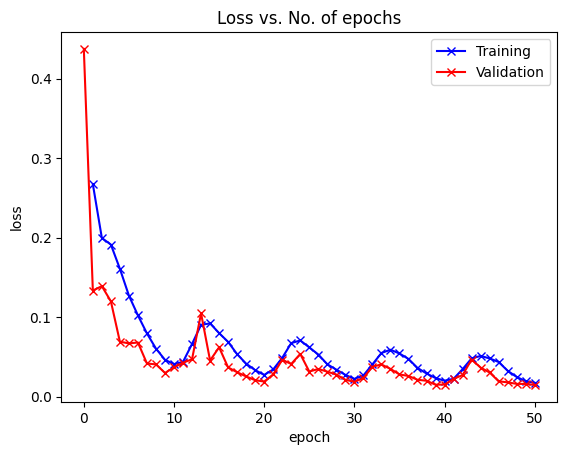

In [49]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

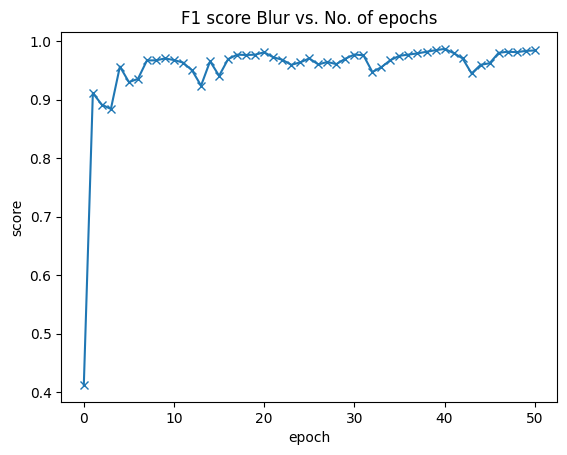

In [50]:
def plot_scores(history):
    scores = [x['val_score_blur'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Blur vs. No. of epochs');
plot_scores(history)

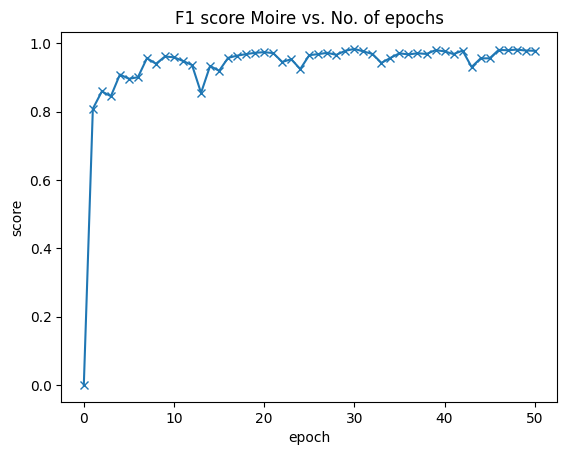

In [51]:
def plot_scores(history):
    scores = [x['val_score_demoir'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Moire vs. No. of epochs');
plot_scores(history)

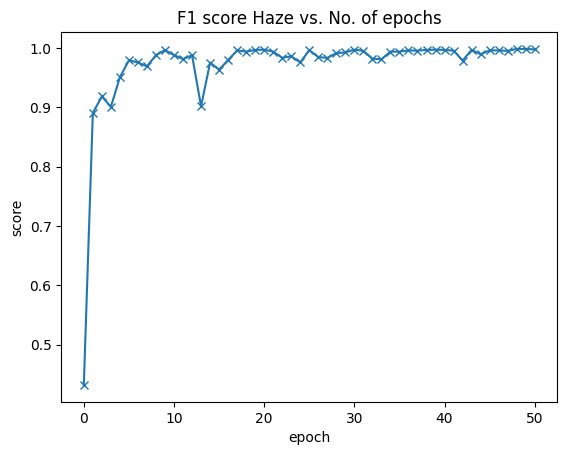

In [52]:
def plot_scores(history):
    scores = [x['val_score_haze'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Haze vs. No. of epochs');
plot_scores(history)

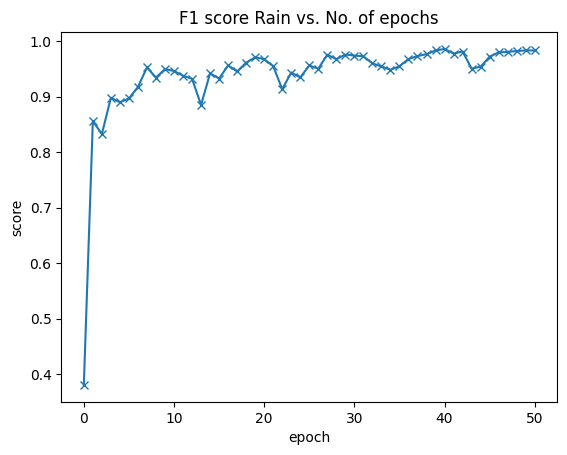

In [53]:
def plot_scores(history):
    scores = [x['val_score_rain'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score Rain vs. No. of epochs');
plot_scores(history)

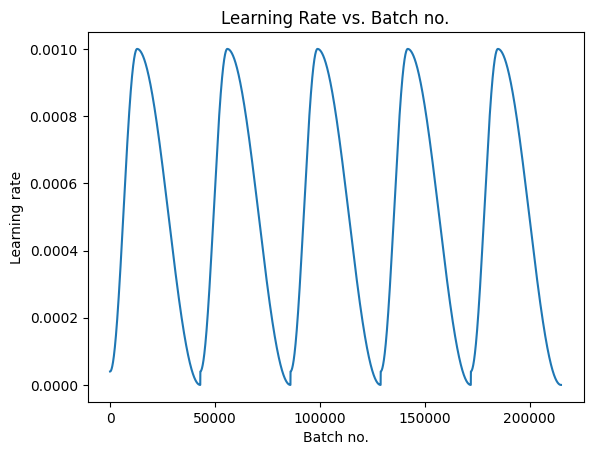

In [54]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');
plot_lrs(history)

In [55]:
def random_image_prediction(url): #This function is to see the predictions of random images from internet.
    image_url = requests.get(url, stream = True).raw
    image = Image.open(image_url)
    image_tensor = val_trans(image).unsqueeze(0)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

Prediction:
Tensor:  tensor([3.9819e-03, 6.9640e-04, 9.9930e-01, 1.4815e-03], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: haze


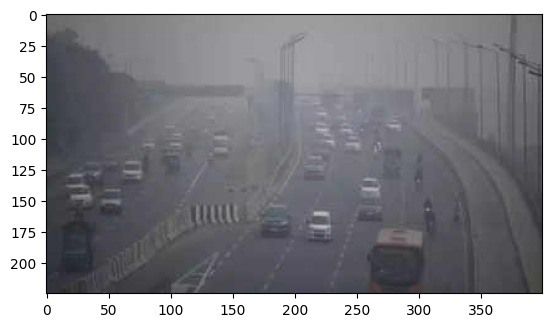

In [56]:
random_image_prediction('https://static.toiimg.com/thumb/msid-88217291,width-400,resizemode-4/88217291.jpg')

Prediction:
Tensor:  tensor([0.9551, 0.0454, 0.0188, 0.0735], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: blur


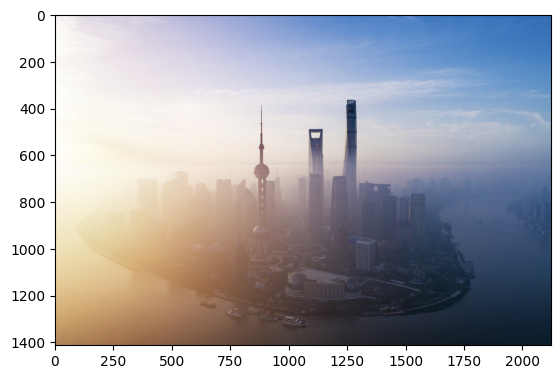

In [57]:
random_image_prediction('https://metro.co.uk/wp-content/uploads/2018/06/gettyimages-682966492.jpg?quality=90&strip=all')

Prediction:
Tensor:  tensor([0.1525, 0.8306, 0.0157, 0.2590], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: demoir


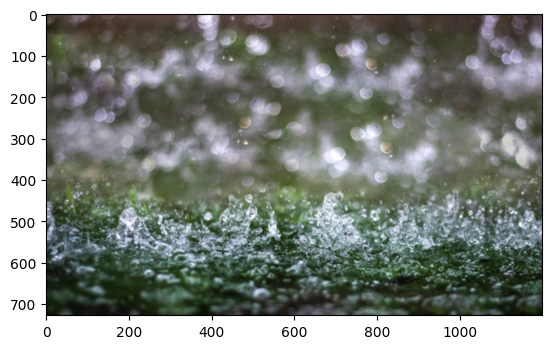

In [58]:
random_image_prediction('https://www.envirostraw.com.au/wp-content/uploads/2022/08/ES-rain-soil-01.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([3.6878e-06, 5.3069e-07, 1.0000e+00, 1.8719e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)


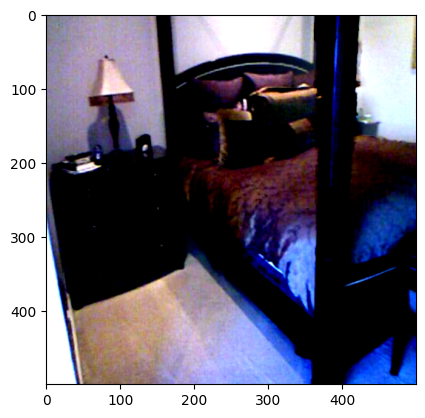

In [59]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)
predict_single(val_dataset[3280][0]) #checking out the predictions of some images from the validation dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: haze

tensor([0., 0., 1., 0.])


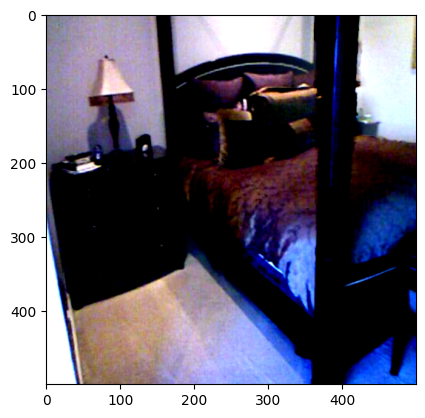

In [60]:
show_example(*val_dataset[3280]) #checking out the predictions of some images from the validation dataset.

In [61]:
PATH = os.path.join('saved_models', datetime.now().strftime('mobilenetv2_customBCE_new_metrics_not_pretrained_13_05_23.pt'))
torch.save(model.state_dict(), PATH)

In [ ]:
loaded_model = CustomModel().to(device)

In [ ]:
loaded_model.load_state_dict(torch.load('saved_models/mobilenetv2_customBCE_new_metrics_not_pretrained_13_05_23.pt'))

In [ ]:
loaded_model.to(device)

In [ ]:
loaded_model.eval()